<a href="https://colab.research.google.com/github/Peheppy/Churn_prediction_with_STab/blob/main/STAB_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STAB - Dados de churn
## Redes Neurais 2025.1
## Grupo 07 (wjls, phas2, jgpt, vjmm, lfasm)

## Imports

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
booleangabs13_customer_churn_splitted_path = kagglehub.dataset_download('booleangabs13/customer-churn-splitted')

print('Data source import complete.')

Data source import complete.


In [ ]:
# Instalações de pacotes
!pip install keras4torch
!pip install einops
!pip install tab-transformer-pytorch
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
!git clone https://github.com/kailanefelix/stab-redes-neurais.git

Cloning into 'stab-redes-neurais'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (87/87), done.
Receiving objects: 100% (97/97), 62.40 KiB | 12.48 MiB/s, done.
remote: Total 97 (delta 43), reused 20 (delta 3), pack-reused 0 (from 0)
Resolving deltas: 100% (43/43), done.


In [ ]:
!ls
%cd stab-redes-neurais
!mv STAB STab

sample_data  stab-redes-neurais
/content/stab-redes-neurais


In [ ]:
# Scikit-learn
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, ConfusionMatrixDisplay, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, LabelEncoder
from sklearn.utils import resample
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from scipy.stats import ks_2samp

# Keras4Torch
import keras4torch
from keras4torch.callbacks import ModelCheckpoint, LRScheduler, EarlyStopping

# STab
import STab
# from STab import *
from STab import mainmodel, LWTA, Gsoftmax, Num_Cat, CatMap

import optuna
from optuna.samplers import TPESampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from einops import rearrange
from tab_transformer_pytorch import TabTransformer
import torch
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import random
import os
from torch.utils.data import DataLoader, TensorDataset
import torch
from scipy.stats import ks_2samp

##Carregamento de dados e preparações

In [ ]:
checkpoint='saved/savefileAD'

In [ ]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [ ]:
data = pd.read_csv("/kaggle/input/customer-churn-splitted/customer_churn_dataset_clean(2).csv")
data.head()

,Tenure,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,split,Churn
0,33,103.75,3361.05,Female,No,Yes,No,Yes,No,Fiber optic,...,No,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,train,Yes
1,1,60.15,60.15,Female,No,No,No,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,train,Yes
2,26,44.45,1183.80,Female,No,No,No,No,No phone service,DSL,...,No,Yes,Yes,Yes,No,Month-to-month,Yes,Credit card (automatic),train,No
3,70,79.25,5731.85,Male,No,Yes,Yes,Yes,Yes,DSL,...,Yes,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),train,No
4,10,20.55,252.75,Female,No,Yes,No,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,train,No


In [ ]:
data.isnull().sum()
data['Churn'].unique()

array(['Yes', 'No'], dtype=object)

vamos ver o quanto de valores de churn positivos e negativos nós temos

In [ ]:
data['Churn'].value_counts()

,count
Churn,
No,5174
Yes,1869


temos muito mais valores negativos em comparação com negativos, será valido fazer um balanceamento adiante

###Teste de Métricas

In [ ]:
def calculate_ks_statistic(model, X_test, y_test, plot=True):
    """
    Calcula a estatística KS e plota as distribuições cumulativas (opcional)

    Args:
        model: Modelo treinado
        X_test: Dados de teste (features)
        y_test: Labels reais (0 ou 1)
        plot: Se True, plota as distribuições cumulativas

    Returns:
        ks_statistic: Valor da estatística KS
        p_value: Valor-p do teste
    """
    # 1. Obter probabilidades previstas
    y_pred_proba = model.predict(X_test)

    # Se o modelo retornar logits (não probabilidades), aplicar sigmoid
    if np.min(y_pred_proba) < 0 or np.max(y_pred_proba) > 1:
        import torch
        y_pred_proba = torch.sigmoid(torch.tensor(y_pred_proba)).numpy()

    # 2. Garantir que y_test esteja no formato correto
    y_test = y_test.flatten()
    y_pred_proba = y_pred_proba.flatten()

    # 3. Separar probabilidades por classe real
    prob_class_0 = y_pred_proba[y_test == 0]
    prob_class_1 = y_pred_proba[y_test == 1]

    # 4. Calcular estatística KS
    ks_statistic, p_value = ks_2samp(prob_class_1, prob_class_0)

    # 5. Plotar as distribuições cumulativas (opcional)
    if plot:
        plt.figure(figsize=(10, 6))

        # Calcular ECDF para cada classe
        def ecdf(x):
            xs = np.sort(x)
            ys = np.arange(1, len(xs)+1)/float(len(xs))
            return xs, ys

        x0, y0 = ecdf(prob_class_0)
        x1, y1 = ecdf(prob_class_1)

        # Criar um grid comum para comparação
        grid = np.linspace(min(np.min(prob_class_0), np.min(prob_class_1)),
                          max(np.max(prob_class_0), np.max(prob_class_1)),
                          1000)

        # Interpolar as ECDFs no grid comum
        y0_grid = np.interp(grid, x0, y0)
        y1_grid = np.interp(grid, x1, y1)

        # Encontrar o ponto de máxima diferença
        diff = np.abs(y1_grid - y0_grid)
        max_diff_idx = np.argmax(diff)
        ks_point = grid[max_diff_idx]

        plt.plot(grid, y0_grid, label='Não Churn (Classe 0)', color='blue')
        plt.plot(grid, y1_grid, label='Churn (Classe 1)', color='red')
        plt.axvline(x=ks_point, color='gray', linestyle='--')
        plt.scatter([ks_point], [y0_grid[max_diff_idx]], color='blue', marker='o')
        plt.scatter([ks_point], [y1_grid[max_diff_idx]], color='red', marker='o')

        plt.title(f'Distribuição Cumulativa - KS = {ks_statistic:.3f}')
        plt.xlabel('Probabilidade Prevista')
        plt.ylabel('Fração Acumulada')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    return ks_statistic, p_value

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ks_2samp

def evaluate_model_metrics(model, X_test, y_test, threshold=0.5, plot_ks=True, plot_cm=True):
    """
    Avalia o modelo com várias métricas: KS, AUC-ROC, F1, AUC-PR e matriz de confusão.

    Args:
        model: modelo treinado (deve ter método predict)
        X_test: features de teste
        y_test: labels reais (0/1)
        threshold: limiar para converter probabilidade em classe
        plot_ks: se True, plota gráfico KS
        plot_cm: se True, plota matriz de confusão

    Retorna:
        dicionário com as métricas calculadas
    """

    # 1. Calcular KS (usando sua função)
    ks_stat, p_val = calculate_ks_statistic(model, X_test, y_test, plot=plot_ks)

    # 2. Obter probabilidades previstas (tratando logits)
    y_pred_proba = model.predict(X_test)
    if np.min(y_pred_proba) < 0 or np.max(y_pred_proba) > 1:
        import torch
        y_pred_proba = torch.sigmoid(torch.tensor(y_pred_proba)).numpy()

    y_test = y_test.flatten()
    y_pred_proba = y_pred_proba.flatten()

    # 3. Converter para classes binárias
    y_pred = (y_pred_proba >= threshold).astype(int)

    # 4. Calcular outras métricas
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    auc_pr = average_precision_score(y_test, y_pred_proba)

    # 5. Matriz de confusão e plot
    cm = confusion_matrix(y_test, y_pred)
    if plot_cm:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title("Matriz de Confusão")
        plt.show()

    # 6. Print resumido
    print(f"KS Statistic: {ks_stat:.4f} (p-value: {p_val:.4g})")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-PR: {auc_pr:.4f}")
    print("Matriz de Confusão:")
    print(cm)

    # 7. Retornar métricas
    return {
        "KS Statistic": ks_stat,
        "KS p-value": p_val,
        "AUC-ROC": auc_roc,
        "F1 Score": f1,
        "AUC-PR": auc_pr,
        "Confusion Matrix": cm
    }


## Pré-processamento

In [ ]:
def prepare_data(data):
    # Identificar colunas
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
    categorical_cols = [col for col in categorical_cols if col not in ['split', 'Churn']]
    numerical_cols = [col for col in data.columns if col not in categorical_cols + ['split', 'Churn']]

    # Separar dados
    train_data = data[data["split"] == "train"].drop("split", axis=1)
    valid_data = data[data["split"] == "valid"].drop("split", axis=1)
    test_data = data[data["split"] == "test"].drop("split", axis=1)

    # Features e targets
    train_X_cat = train_data[categorical_cols].copy()
    train_X_num = train_data[numerical_cols].copy()
    valid_X_cat = valid_data[categorical_cols].copy()
    valid_X_num = valid_data[numerical_cols].copy()
    test_X_cat = test_data[categorical_cols].copy()
    test_X_num = test_data[numerical_cols].copy()

    train_y = train_data["Churn"]
    valid_y = valid_data["Churn"]
    test_y = test_data["Churn"]

    # Tratamento de NaN em colunas numéricas
    for df in [train_X_num, valid_X_num, test_X_num]:
        for col in numerical_cols:
            if df[col].isna().any():
                m = train_X_num[col].median()
                df[col] = df[col].fillna(m)

    # Normalização das numéricas
    scaler = StandardScaler()
    train_X_num = scaler.fit_transform(train_X_num).astype(np.float32)
    valid_X_num = scaler.transform(valid_X_num).astype(np.float32)
    test_X_num = scaler.transform(test_X_num).astype(np.float32)

    # Codificação das categóricas (para índices)
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        train_X_cat[col] = le.fit_transform(train_X_cat[col])
        valid_X_cat[col] = le.transform(valid_X_cat[col])
        test_X_cat[col] = le.transform(test_X_cat[col])
        label_encoders[col] = le

    catmap = CatMap(train_X_cat)
    train_X_cat = catmap(train_X_cat)
    valid_X_cat = catmap(valid_X_cat)
    test_X_cat = catmap(test_X_cat)

    #combine numerical and categorical
    X_train = np.concatenate([train_X_num,train_X_cat.values],axis=1)
    X_test  = np.concatenate([test_X_num,test_X_cat.values],axis=1)
    X_valid = np.concatenate([valid_X_num,valid_X_cat.values],axis=1)


    return X_train, X_valid, X_test, train_y, valid_y, test_y, categorical_cols, numerical_cols

# Carregar os dados
X_train, X_valid, X_test, train_y, valid_y, test_y, categorical_cols, numerical_cols = prepare_data(data)

In [ ]:
# Após chamar prepare_data(), podemos verificar:
n_numerical = X_train.shape[1] - len(categorical_cols)
n_categorical = len(categorical_cols)

print(f"Número de variáveis numéricas: {n_numerical}")
print(f"Número de variáveis categóricas: {n_categorical}")

Número de variáveis numéricas: 3
Número de variáveis categóricas: 16


In [ ]:
# Para cada coluna categórica, contar os valores únicos
categorical_cardinalities = [len(data[col].unique()) for col in categorical_cols]

print("Número de categorias por variável:")
for col, n in zip(categorical_cols, categorical_cardinalities):
    print(f"{col}: {n} categorias")

Número de categorias por variável:
Gender: 2 categorias
SeniorCitizen: 2 categorias
Partner: 2 categorias
Dependents: 2 categorias
PhoneService: 2 categorias
MultipleLines: 3 categorias
InternetService: 3 categorias
OnlineSecurity: 3 categorias
OnlineBackup: 3 categorias
DeviceProtection: 3 categorias
TechSupport: 3 categorias
StreamingTV: 3 categorias
StreamingMovies: 3 categorias
Contract: 3 categorias
PaperlessBilling: 2 categorias
PaymentMethod: 4 categorias


In [ ]:
train_y = train_y.map({'No': 0, 'Yes': 1}).astype(np.float32).to_numpy()
valid_y = valid_y.map({'No': 0, 'Yes': 1}).astype(np.float32).to_numpy()
test_y  = test_y.map({'No': 0, 'Yes': 1}).astype(np.float32).to_numpy()

In [ ]:
X_train = X_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)
X_test  = X_test.astype(np.float32)

train_y = train_y.reshape(-1, 1).astype(np.float32)
valid_y = valid_y.reshape(-1, 1).astype(np.float32)
test_y  = test_y.reshape(-1, 1).astype(np.float32)

##Modelo Desbalanceado (Base)

### Configurações

In [ ]:
stab_config = {
    # Configurações do otimizador
    "optim": optim.AdamW,
    "optim_lr": 1e-4,
    "optim_wd": 1e-5,
    "loss": nn.BCEWithLogitsLoss(),  # Melhor para classificação binária

    # Arquitetura da rede
    "dim": 32,                      # Dimensão maior para embeddings
    "depth": 3,                     # Profundidade do transformer
    "heads": 4,
    "attn_dp": 0.1,
    "ff_dp": 0.1,
    "U": 2,
    "cases": 8,

    # Controle de treino
    "verbose": 2,
    "epochs": 60,
    "bs": 64,
    "metrics": ["accuracy"]
}

### Definição de Modelo

In [ ]:
# Definir o modelo STAB
model = mainmodel.MainModel(
    categories=(2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4),          # Lista com número de categorias únicas por feature
    num_continuous=3,
    dim            = stab_config["dim"],
    dim_out        = 1,               # saída binária
    depth          = stab_config["depth"],
    heads          = stab_config["heads"],
    attn_dropout   = stab_config["attn_dp"],
    ff_dropout     = stab_config["ff_dp"],
    U              = stab_config["U"],
    cases          = stab_config["cases"],
)

45


In [ ]:
# Criar wrapper Num_Cat
model_wrapper = Num_Cat(
    model,
    num_number=3,
    classes=1,
    Sample_size=16
)

# Criar modelo keras4torch
model = keras4torch.Model(model_wrapper).build([19])

# Configurar otimizador usando o dicionário
optimizer = stab_config["optim"](
    model.parameters(),
    lr=stab_config["optim_lr"],
    weight_decay=stab_config["optim_wd"]
)

sch=torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=10,  verbose=False)

callbacks=[ModelCheckpoint(checkpoint,monitor='val_acc',mode='max'),LRScheduler(sch)]

model.compile(
    optimizer=optimizer,
    loss=stab_config["loss"],
    metrics=stab_config["metrics"]
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Treinamento

In [ ]:
model.fit(X_train, train_y,
          epochs=stab_config["epochs"], batch_size=stab_config["bs"],
          validation_data=([X_valid], valid_y),
          verbose=stab_config["verbose"],
          callbacks = callbacks)

Train on 3521 samples, validate on 1761 samples:
Epoch 1/60 - 12s - loss: 0.6933 - acc: 0.5354 - val_loss: 0.6352 - val_acc: 0.6809 - lr: 1e-05
Epoch 2/60 - 11s - loss: 0.6077 - acc: 0.6867 - val_loss: 0.5714 - val_acc: 0.7342 - lr: 1.9e-05
Epoch 3/60 - 11s - loss: 0.5554 - acc: 0.7299 - val_loss: 0.5388 - val_acc: 0.7342 - lr: 2.8e-05
Epoch 4/60 - 11s - loss: 0.5274 - acc: 0.7367 - val_loss: 0.5147 - val_acc: 0.7342 - lr: 3.7e-05
Epoch 5/60 - 10s - loss: 0.5052 - acc: 0.7444 - val_loss: 0.4945 - val_acc: 0.7422 - lr: 4.6e-05
Epoch 6/60 - 10s - loss: 0.4799 - acc: 0.7552 - val_loss: 0.4761 - val_acc: 0.7751 - lr: 5.5e-05
Epoch 7/60 - 11s - loss: 0.4620 - acc: 0.7807 - val_loss: 0.4640 - val_acc: 0.7808 - lr: 6.4e-05
Epoch 8/60 - 12s - loss: 0.4641 - acc: 0.7736 - val_loss: 0.4567 - val_acc: 0.7888 - lr: 7.3e-05
Epoch 9/60 - 11s - loss: 0.4449 - acc: 0.7927 - val_loss: 0.4495 - val_acc: 0.7899 - lr: 8.2e-05
Epoch 10/60 - 11s - loss: 0.4437 - acc: 0.7898 - val_loss: 0.4469 - val_acc: 0.7

,loss,acc,val_loss,val_acc,lr
1,0.693324,0.535359,0.635178,0.680863,0.000010
2,0.607686,0.686737,0.571405,0.734242,0.000019
3,0.555363,0.729906,0.538781,0.734242,0.000028
4,0.527432,0.736723,0.514704,0.734242,0.000037
5,0.505172,0.744391,0.494544,0.742192,0.000046
6,0.479879,0.755183,0.476107,0.775128,0.000055
7,0.461997,0.780744,0.464038,0.780806,0.000064
8,0.464074,0.773644,0.456698,0.788756,0.000073
9,0.444870,0.792673,0.449475,0.789892,0.000082
10,0.443660,0.789832,0.446873,0.792164,0.000091


### Teste

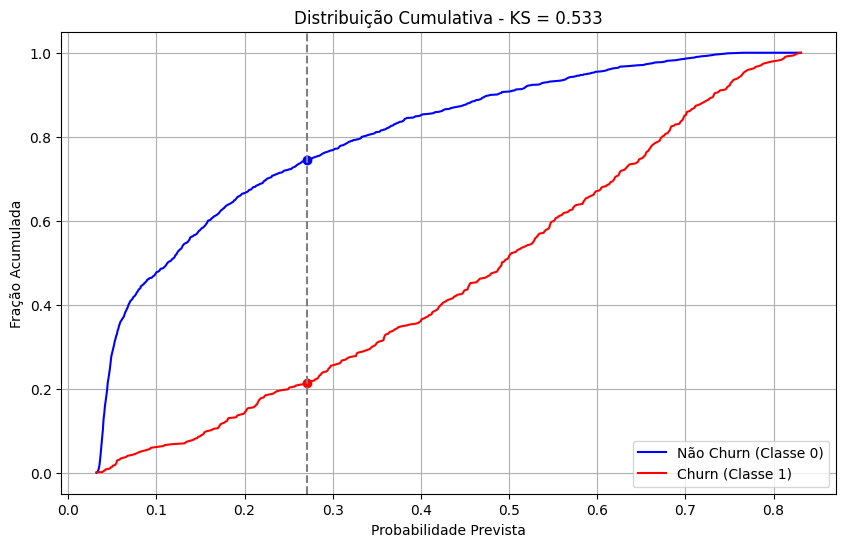

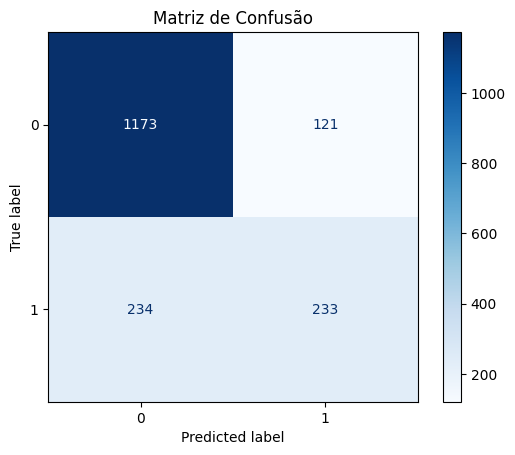

KS Statistic: 0.5327 (p-value: 4.504e-90)
AUC-ROC: 0.8391
F1 Score: 0.5676
AUC-PR: 0.6523
Matriz de Confusão:
[[1173  121]
 [ 234  233]]


In [ ]:
results = evaluate_model_metrics(model, X_test, test_y)

##Modelo balanceado

### Balanceamento

In [ ]:
# Correção para o balanceamento
def balance_data(X_train, train_y):
    """
    Balanceia os dados usando oversampling da classe minoritária

    Args:
        X_train: Features de treino (array numpy)
        train_y: Labels de treino (array numpy)

    Returns:
        X_balanced: Features balanceadas
        y_balanced: Labels balanceados (como tensor torch)
    """
    # Junta X e y para facilitar
    train_df = pd.DataFrame(X_train)
    train_df["target"] = train_y.squeeze()  # Já é numpy, não precisa de .numpy()

    # Separa classes
    majority = train_df[train_df.target == 0]
    minority = train_df[train_df.target == 1]

    # Oversample a minoria
    minority_upsampled = resample(minority,
                                replace=True,
                                n_samples=len(majority),
                                random_state=42)

    # Junta de novo
    balanced_df = pd.concat([majority, minority_upsampled])

    # Embaralhar
    balanced_df = balanced_df.sample(frac=1, random_state=42)

    # Separa X e y
    X_balanced = balanced_df.drop("target", axis=1).values.astype(np.float32)
    y_balanced = torch.tensor(balanced_df["target"].values, dtype=torch.float32).unsqueeze(1)

    return X_balanced, y_balanced

In [ ]:
train_X_bal, train_y_bal = balance_data(X_train, train_y)

### Definição de Modelo

In [ ]:
# Definir o modelo STAB
model = mainmodel.MainModel(
    categories=(2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4),          # Lista com número de categorias únicas por feature
    num_continuous=3,
    dim            = stab_config["dim"],
    dim_out        = 1,               # saída binária
    depth          = stab_config["depth"],
    heads          = stab_config["heads"],
    attn_dropout   = stab_config["attn_dp"],
    ff_dropout     = stab_config["ff_dp"],
    U              = stab_config["U"],
    cases          = stab_config["cases"],
)

In [ ]:
# Criar wrapper Num_Cat
model_wrapper = Num_Cat(
    model,
    num_number=3,
    classes=1,
    Sample_size=16
)

# Criar modelo keras4torch
model = keras4torch.Model(model_wrapper).build([19])

# Configurar otimizador usando o dicionário
optimizer = stab_config["optim"](
    model.parameters(),
    lr=stab_config["optim_lr"],
    weight_decay=stab_config["optim_wd"]
)

sch=torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=10,  verbose=False)

callbacks=[ModelCheckpoint(checkpoint,monitor='val_acc',mode='max'),LRScheduler(sch)]

model.compile(
    optimizer=optimizer,
    loss=stab_config["loss"],
    metrics=stab_config["metrics"]
)

### Treinamento

In [ ]:
model.fit(train_X_bal, train_y_bal,
          epochs=stab_config["epochs"], batch_size=stab_config["bs"],
          validation_data=([X_valid], valid_y),
          verbose=stab_config["verbose"],
          callbacks = callbacks)

### Teste

In [ ]:
results = evaluate_model_metrics(model, X_test, test_y)

## Modelo com maior profundidade

### Configurações

In [ ]:
stab_config = {
    # config optimizer
    "optim": optim.AdamW,
    "optim_lr": 1e-4,
    "optim_wd": 1e-5,
    "loss": nn.BCEWithLogitsLoss(),  # Melhor para classificação binária

    # Arquitetura da rede
    "dim": 16,                      # Número de camadas STAB
    "depth": 10,                   # Dimensão dos embeddings espaço-temporais
    "heads": 4,                       # Número de heads de atenção
    "attn_dp": 0.1,                     # Dropout para regularização
    "ff_dp": 0.1,
    "U": 2,
    "cases": 8,

    # Controle de treino
    "verbose": 2,
    "epochs": 60,
    "bs": 64,
    "metrics": ["accuracy"]
}

### Definição de Modelo

In [ ]:
# Definir o modelo STAB
model = mainmodel.MainModel(
    categories=(2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4),          # Lista com número de categorias únicas por feature
    num_continuous=3,
    dim            = stab_config["dim"],
    dim_out        = 1,               # saída binária
    depth          = stab_config["depth"],
    heads          = stab_config["heads"],
    attn_dropout   = stab_config["attn_dp"],
    ff_dropout     = stab_config["ff_dp"],
    U              = stab_config["U"],
    cases          = stab_config["cases"],
)

45


In [ ]:
# Criar wrapper Num_Cat
model_wrapper = Num_Cat(
    model,
    num_number=3,
    classes=1,
    Sample_size=16
)

# Criar modelo keras4torch
model = keras4torch.Model(model_wrapper).build([19])

# Configurar otimizador usando o dicionário
optimizer = stab_config["optim"](
    model.parameters(),
    lr=stab_config["optim_lr"],
    weight_decay=stab_config["optim_wd"]
)

sch=torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=10,  verbose=False)

callbacks=[ModelCheckpoint(checkpoint,monitor='val_acc',mode='max'),LRScheduler(sch)]

model.compile(
    optimizer=optimizer,
    loss=stab_config["loss"],
    metrics=stab_config["metrics"]
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Treinamento

Train on 5174 samples, validate on 1761 samples:
Epoch 1/60 - 49s - loss: 0.6996 - acc: 0.5506 - val_loss: 0.7018 - val_acc: 0.5082 - lr: 1e-05
Epoch 2/60 - 49s - loss: 0.6559 - acc: 0.6138 - val_loss: 0.6348 - val_acc: 0.6525 - lr: 1.9e-05
Epoch 3/60 - 48s - loss: 0.6079 - acc: 0.6811 - val_loss: 0.5863 - val_acc: 0.7104 - lr: 2.8e-05
Epoch 4/60 - 48s - loss: 0.5502 - acc: 0.7381 - val_loss: 0.5381 - val_acc: 0.7376 - lr: 3.7e-05
Epoch 5/60 - 48s - loss: 0.5300 - acc: 0.7493 - val_loss: 0.5229 - val_acc: 0.7445 - lr: 4.6e-05
Epoch 6/60 - 48s - loss: 0.5225 - acc: 0.7536 - val_loss: 0.5383 - val_acc: 0.7240 - lr: 5.5e-05
Epoch 7/60 - 48s - loss: 0.5112 - acc: 0.7574 - val_loss: 0.5200 - val_acc: 0.7405 - lr: 6.4e-05
Epoch 8/60 - 48s - loss: 0.5075 - acc: 0.7545 - val_loss: 0.5436 - val_acc: 0.7223 - lr: 7.3e-05
Epoch 9/60 - 47s - loss: 0.5022 - acc: 0.7634 - val_loss: 0.5280 - val_acc: 0.7303 - lr: 8.2e-05
Epoch 10/60 - 48s - loss: 0.4992 - acc: 0.7638 - val_loss: 0.5269 - val_acc: 0.7

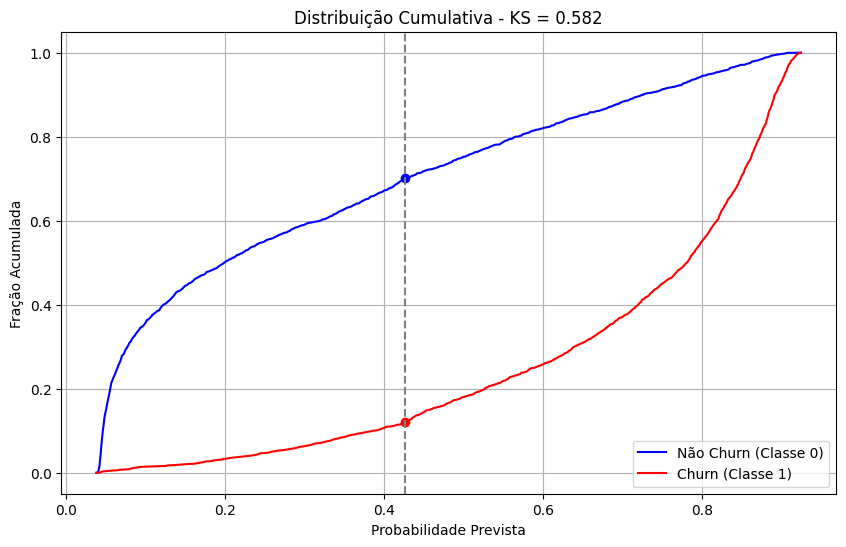

KS Statistic: 0.5818
p-value: 0.0000


In [ ]:
model.fit(train_X_bal, train_y_bal,
          epochs=stab_config["epochs"], batch_size=stab_config["bs"],
          validation_data=([X_valid], valid_y),
          verbose=stab_config["verbose"],
          callbacks = callbacks)

ks_stat, p_val = calculate_ks_statistic(model, train_X_bal, train_y_bal)

print(f"KS Statistic: {ks_stat:.4f}")
print(f"p-value: {p_val:.4f}")

## Modelo com mais heads

###Configurações

In [ ]:
stab_config = {
    # config optimizer
    "optim": optim.AdamW,
    "optim_lr": 1e-4,
    "optim_wd": 1e-5,
    "loss": nn.BCEWithLogitsLoss(),  # Melhor para classificação binária

    # Arquitetura da rede
    "dim": 16,                      # Número de camadas STAB
    "depth": 2,                   # Dimensão dos embeddings espaço-temporais
    "heads": 16,                       # Número de heads de atenção
    "attn_dp": 0.1,                     # Dropout para regularização
    "ff_dp": 0.1,
    "U": 2,
    "cases": 8,

    # Controle de treino
    "verbose": 2,
    "epochs": 60,
    "bs": 64,
    "metrics": ["accuracy"]
}

### Definição de Modelo

In [ ]:
# Definir o modelo STAB
model = mainmodel.MainModel(
    categories=(2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4),          # Lista com número de categorias únicas por feature
    num_continuous=3,
    dim            = stab_config["dim"],
    dim_out        = 1,               # saída binária
    depth          = stab_config["depth"],
    heads          = stab_config["heads"],
    attn_dropout   = stab_config["attn_dp"],
    ff_dropout     = stab_config["ff_dp"],
    U              = stab_config["U"],
    cases          = stab_config["cases"],
)

45


In [ ]:
# Criar wrapper Num_Cat
model_wrapper = Num_Cat(
    model,
    num_number=3,
    classes=1,
    Sample_size=16
)

# Criar modelo keras4torch
model = keras4torch.Model(model_wrapper).build([19])

# Configurar otimizador usando o dicionário
optimizer = stab_config["optim"](
    model.parameters(),
    lr=stab_config["optim_lr"],
    weight_decay=stab_config["optim_wd"]
)

sch=torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=10,  verbose=False)

callbacks=[ModelCheckpoint(checkpoint,monitor='val_acc',mode='max'),LRScheduler(sch)]

model.compile(
    optimizer=optimizer,
    loss=stab_config["loss"],
    metrics=stab_config["metrics"]
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Treinamento

Train on 5174 samples, validate on 1761 samples:
Epoch 1/60 - 11s - loss: 0.6963 - acc: 0.5443 - val_loss: 0.6189 - val_acc: 0.7252 - lr: 1e-05
Epoch 2/60 - 11s - loss: 0.6519 - acc: 0.6191 - val_loss: 0.6212 - val_acc: 0.7081 - lr: 1.9e-05
Epoch 3/60 - 11s - loss: 0.6153 - acc: 0.6734 - val_loss: 0.5965 - val_acc: 0.6979 - lr: 2.8e-05
Epoch 4/60 - 12s - loss: 0.5789 - acc: 0.7087 - val_loss: 0.5706 - val_acc: 0.6973 - lr: 3.7e-05
Epoch 5/60 - 11s - loss: 0.5515 - acc: 0.7313 - val_loss: 0.5512 - val_acc: 0.7115 - lr: 4.6e-05
Epoch 6/60 - 11s - loss: 0.5383 - acc: 0.7387 - val_loss: 0.5589 - val_acc: 0.7024 - lr: 5.5e-05
Epoch 7/60 - 11s - loss: 0.5226 - acc: 0.7495 - val_loss: 0.5507 - val_acc: 0.7070 - lr: 6.4e-05
Epoch 8/60 - 12s - loss: 0.5142 - acc: 0.7528 - val_loss: 0.5313 - val_acc: 0.7257 - lr: 7.3e-05
Epoch 9/60 - 12s - loss: 0.5065 - acc: 0.7565 - val_loss: 0.5265 - val_acc: 0.7286 - lr: 8.2e-05
Epoch 10/60 - 12s - loss: 0.4988 - acc: 0.7561 - val_loss: 0.4963 - val_acc: 0.7

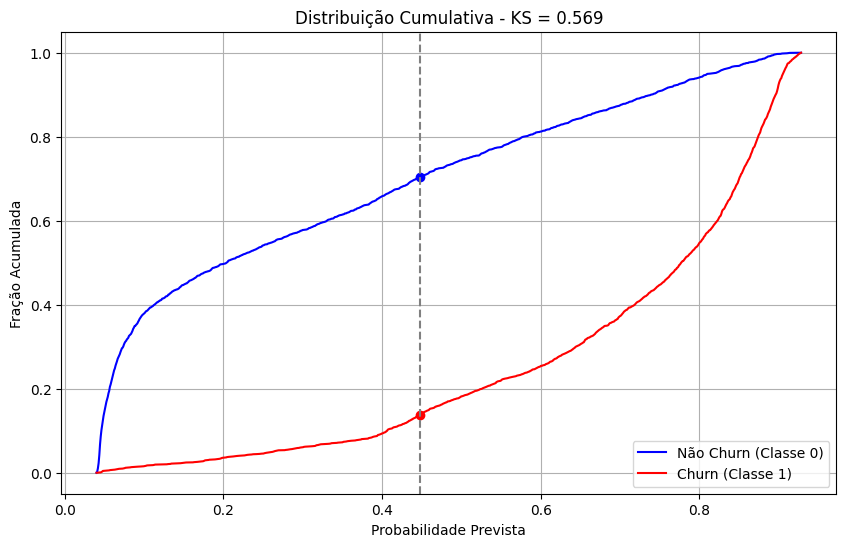

KS Statistic: 0.5686
p-value: 0.0000


In [ ]:
model.fit(train_X_bal, train_y_bal,
          epochs=stab_config["epochs"], batch_size=stab_config["bs"],
          validation_data=([X_valid], valid_y),
          verbose=stab_config["verbose"],
          callbacks = callbacks)

ks_stat, p_val = calculate_ks_statistic(model, train_X_bal, train_y_bal)

print(f"KS Statistic: {ks_stat:.4f}")
print(f"p-value: {p_val:.4f}")

## Modelo com mais unidades por grupo de competição

###Configurações

In [ ]:
stab_config = {
    # config optimizer
    "optim": optim.AdamW,
    "optim_lr": 1e-4,
    "optim_wd": 1e-5,
    "loss": nn.BCEWithLogitsLoss(),  # Melhor para classificação binária

    # Arquitetura da rede
    "dim": 16,                      # Número de camadas STAB
    "depth": 2,                   # Dimensão dos embeddings espaço-temporais
    "heads": 4,                       # Número de heads de atenção
    "attn_dp": 0.1,                     # Dropout para regularização
    "ff_dp": 0.1,
    "U": 8,
    "cases": 8,

    # Controle de treino
    "verbose": 2,
    "epochs": 60,
    "bs": 64,
    "metrics": ["accuracy"]
}

### Definição de Modelo

In [ ]:
# Definir o modelo STAB
model = mainmodel.MainModel(
    categories=(2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4),          # Lista com número de categorias únicas por feature
    num_continuous=3,
    dim            = stab_config["dim"],
    dim_out        = 1,               # saída binária
    depth          = stab_config["depth"],
    heads          = stab_config["heads"],
    attn_dropout   = stab_config["attn_dp"],
    ff_dropout     = stab_config["ff_dp"],
    U              = stab_config["U"],
    cases          = stab_config["cases"],
)

45


In [ ]:
# Criar wrapper Num_Cat
model_wrapper = Num_Cat(
    model,
    num_number=3,
    classes=1,
    Sample_size=16
)

# Criar modelo keras4torch
model = keras4torch.Model(model_wrapper).build([19])

# Configurar otimizador usando o dicionário
optimizer = stab_config["optim"](
    model.parameters(),
    lr=stab_config["optim_lr"],
    weight_decay=stab_config["optim_wd"]
)

sch=torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=10,  verbose=False)

callbacks=[ModelCheckpoint(checkpoint,monitor='val_acc',mode='max'),LRScheduler(sch)]

model.compile(
    optimizer=optimizer,
    loss=stab_config["loss"],
    metrics=stab_config["metrics"]
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Treinamento

Train on 5174 samples, validate on 1761 samples:
Epoch 1/60 - 11s - loss: 0.6958 - acc: 0.5363 - val_loss: 0.6313 - val_acc: 0.6973 - lr: 1e-05
Epoch 2/60 - 11s - loss: 0.6763 - acc: 0.5709 - val_loss: 0.6351 - val_acc: 0.6934 - lr: 1.9e-05
Epoch 3/60 - 11s - loss: 0.6491 - acc: 0.6164 - val_loss: 0.6282 - val_acc: 0.6826 - lr: 2.8e-05
Epoch 4/60 - 11s - loss: 0.6201 - acc: 0.6687 - val_loss: 0.6038 - val_acc: 0.6945 - lr: 3.7e-05
Epoch 5/60 - 11s - loss: 0.5899 - acc: 0.7053 - val_loss: 0.5809 - val_acc: 0.7007 - lr: 4.6e-05
Epoch 6/60 - 10s - loss: 0.5703 - acc: 0.7126 - val_loss: 0.5632 - val_acc: 0.7144 - lr: 5.5e-05
Epoch 7/60 - 11s - loss: 0.5450 - acc: 0.7346 - val_loss: 0.5388 - val_acc: 0.7257 - lr: 6.4e-05
Epoch 8/60 - 11s - loss: 0.5359 - acc: 0.7431 - val_loss: 0.5402 - val_acc: 0.7212 - lr: 7.3e-05
Epoch 9/60 - 11s - loss: 0.5230 - acc: 0.7501 - val_loss: 0.5347 - val_acc: 0.7263 - lr: 8.2e-05
Epoch 10/60 - 11s - loss: 0.5194 - acc: 0.7551 - val_loss: 0.5299 - val_acc: 0.7

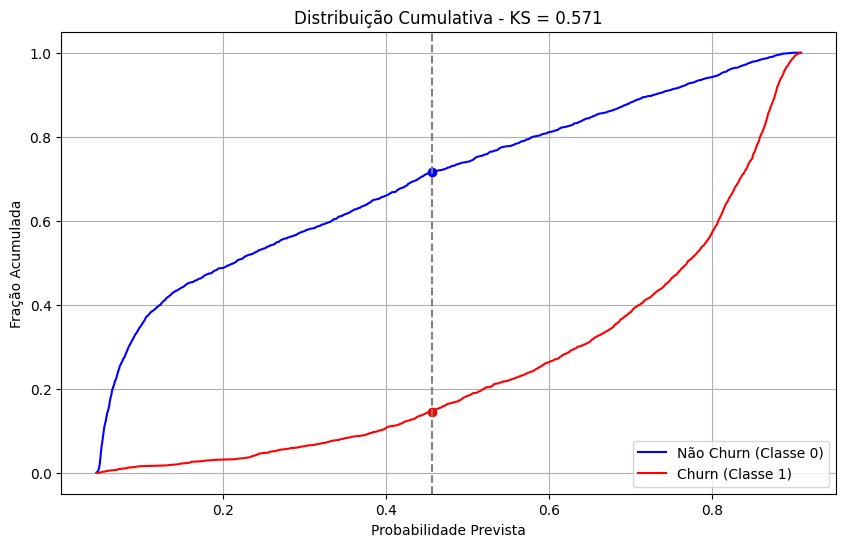

KS Statistic: 0.5705
p-value: 0.0000


In [ ]:
model.fit(train_X_bal, train_y_bal,
          epochs=stab_config["epochs"], batch_size=stab_config["bs"],
          validation_data=([X_valid], valid_y),
          verbose=stab_config["verbose"],
          callbacks = callbacks)

ks_stat, p_val = calculate_ks_statistic(model, train_X_bal, train_y_bal)

print(f"KS Statistic: {ks_stat:.4f}")
print(f"p-value: {p_val:.4f}")

## Modelo com maior dimensão

###Configurações

In [ ]:
stab_config = {
    # config optimizer
    "optim": optim.AdamW,
    "optim_lr": 1e-4,
    "optim_wd": 1e-5,
    "loss": nn.BCEWithLogitsLoss(),  # Melhor para classificação binária

    # Arquitetura da rede
    "dim": 32,                      # Número de camadas STAB
    "depth": 2,                   # Dimensão dos embeddings espaço-temporais
    "heads": 16,                       # Número de heads de atenção
    "attn_dp": 0.1,                     # Dropout para regularização
    "ff_dp": 0.1,
    "U": 8,
    "cases": 8,

    # Controle de treino
    "verbose": 2,
    "epochs": 60,
    "bs": 64,
    "metrics": ["accuracy"]
}

### Definição de Modelo

In [ ]:
# Definir o modelo STAB
model = mainmodel.MainModel(
    categories=(2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4),          # Lista com número de categorias únicas por feature
    num_continuous=3,
    dim            = stab_config["dim"],
    dim_out        = 1,               # saída binária
    depth          = stab_config["depth"],
    heads          = stab_config["heads"],
    attn_dropout   = stab_config["attn_dp"],
    ff_dropout     = stab_config["ff_dp"],
    U              = stab_config["U"],
    cases          = stab_config["cases"],
)

45


In [ ]:
# Criar wrapper Num_Cat
model_wrapper = Num_Cat(
    model,
    num_number=3,
    classes=1,
    Sample_size=16
)

# Criar modelo keras4torch
model = keras4torch.Model(model_wrapper).build([19])

# Configurar otimizador usando o dicionário
optimizer = stab_config["optim"](
    model.parameters(),
    lr=stab_config["optim_lr"],
    weight_decay=stab_config["optim_wd"]
)

sch=torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=10,  verbose=False)

callbacks=[ModelCheckpoint(checkpoint,monitor='val_acc',mode='max'),LRScheduler(sch)]

model.compile(
    optimizer=optimizer,
    loss=stab_config["loss"],
    metrics=stab_config["metrics"]
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Treinamento

Train on 5174 samples, validate on 1761 samples:
Epoch 1/60 - 12s - loss: 0.6876 - acc: 0.5539 - val_loss: 0.6222 - val_acc: 0.7564 - lr: 1e-05
Epoch 2/60 - 12s - loss: 0.6399 - acc: 0.6554 - val_loss: 0.6198 - val_acc: 0.7274 - lr: 1.9e-05
Epoch 3/60 - 12s - loss: 0.5904 - acc: 0.7111 - val_loss: 0.5766 - val_acc: 0.7359 - lr: 2.8e-05
Epoch 4/60 - 12s - loss: 0.5514 - acc: 0.7435 - val_loss: 0.5368 - val_acc: 0.7479 - lr: 3.7e-05
Epoch 5/60 - 12s - loss: 0.5236 - acc: 0.7464 - val_loss: 0.5296 - val_acc: 0.7445 - lr: 4.6e-05
Epoch 6/60 - 12s - loss: 0.5102 - acc: 0.7590 - val_loss: 0.5087 - val_acc: 0.7501 - lr: 5.5e-05
Epoch 7/60 - 12s - loss: 0.5033 - acc: 0.7605 - val_loss: 0.5024 - val_acc: 0.7524 - lr: 6.4e-05
Epoch 8/60 - 12s - loss: 0.4971 - acc: 0.7654 - val_loss: 0.4980 - val_acc: 0.7547 - lr: 7.3e-05
Epoch 9/60 - 12s - loss: 0.4888 - acc: 0.7658 - val_loss: 0.5176 - val_acc: 0.7428 - lr: 8.2e-05
Epoch 10/60 - 12s - loss: 0.4883 - acc: 0.7619 - val_loss: 0.4943 - val_acc: 0.7

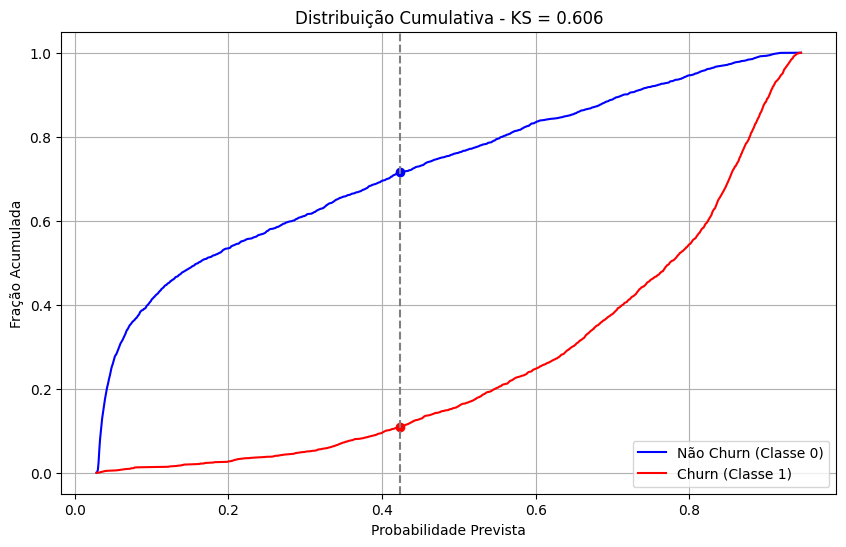

KS Statistic: 0.6065
p-value: 0.0000


In [ ]:
model.fit(train_X_bal, train_y_bal,
          epochs=stab_config["epochs"], batch_size=stab_config["bs"],
          validation_data=([X_valid], valid_y),
          verbose=stab_config["verbose"],
          callbacks = callbacks)

ks_stat, p_val = calculate_ks_statistic(model, train_X_bal, train_y_bal)

print(f"KS Statistic: {ks_stat:.4f}")
print(f"p-value: {p_val:.4f}")

## Modelo Avg

###Configurações

In [ ]:
stab_config = {
    # Configurações do otimizador
    "optim": optim.AdamW,
    "optim_lr": 1e-4,
    "optim_wd": 1e-5,
    "loss": nn.BCEWithLogitsLoss(),  # Melhor para classificação binária

    # Arquitetura da rede
    "dim": 32,                      # Dimensão maior para embeddings
    "depth": 9,                     # Profundidade do transformer
    "heads": 8,
    "attn_dp": 0.1,
    "ff_dp": 0.1,
    "U": 4,
    "cases": 8,

    # Controle de treino
    "verbose": 2,
    "epochs": 60,
    "bs": 64,
    "metrics": ["accuracy"]
}

### Definição de Modelo

In [ ]:
# Definir o modelo STAB
model = mainmodel.MainModel(
    categories=(2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4),          # Lista com número de categorias únicas por feature
    num_continuous=3,
    dim            = stab_config["dim"],
    dim_out        = 1,               # saída binária
    depth          = stab_config["depth"],
    heads          = stab_config["heads"],
    attn_dropout   = stab_config["attn_dp"],
    ff_dropout     = stab_config["ff_dp"],
    U              = stab_config["U"],
    cases          = stab_config["cases"],
)

45


In [ ]:
# Criar wrapper Num_Cat
model_wrapper = Num_Cat(
    model,
    num_number=3,
    classes=1,
    Sample_size=16
)

# Criar modelo keras4torch
model = keras4torch.Model(model_wrapper).build([19])

# Configurar otimizador usando o dicionário
optimizer = stab_config["optim"](
    model.parameters(),
    lr=stab_config["optim_lr"],
    weight_decay=stab_config["optim_wd"]
)

sch=torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=10,  verbose=False)

callbacks=[ModelCheckpoint(checkpoint,monitor='val_acc',mode='max'),LRScheduler(sch)]

model.compile(
    optimizer=optimizer,
    loss=stab_config["loss"],
    metrics=stab_config["metrics"]
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Treinamento

In [ ]:
model.fit(train_X_bal, train_y_bal,
          epochs=stab_config["epochs"], batch_size=stab_config["bs"],
          validation_data=([X_valid], valid_y),
          verbose=stab_config["verbose"],
          callbacks = callbacks)

Train on 5174 samples, validate on 1761 samples:
Epoch 1/60 - 45s - loss: 0.6778 - acc: 0.5754 - val_loss: 0.6543 - val_acc: 0.6536 - lr: 1e-05
Epoch 2/60 - 43s - loss: 0.5873 - acc: 0.7085 - val_loss: 0.5720 - val_acc: 0.7189 - lr: 1.9e-05
Epoch 3/60 - 44s - loss: 0.5284 - acc: 0.7458 - val_loss: 0.5299 - val_acc: 0.7359 - lr: 2.8e-05
Epoch 4/60 - 44s - loss: 0.5083 - acc: 0.7607 - val_loss: 0.5468 - val_acc: 0.7223 - lr: 3.7e-05
Epoch 5/60 - 44s - loss: 0.4949 - acc: 0.7656 - val_loss: 0.5457 - val_acc: 0.7206 - lr: 4.6e-05
Epoch 6/60 - 43s - loss: 0.4962 - acc: 0.7619 - val_loss: 0.5329 - val_acc: 0.7269 - lr: 5.5e-05
Epoch 7/60 - 45s - loss: 0.4893 - acc: 0.7663 - val_loss: 0.5118 - val_acc: 0.7411 - lr: 6.4e-05
Epoch 8/60 - 44s - loss: 0.4866 - acc: 0.7675 - val_loss: 0.5211 - val_acc: 0.7320 - lr: 7.3e-05
Epoch 9/60 - 43s - loss: 0.4843 - acc: 0.7650 - val_loss: 0.5191 - val_acc: 0.7291 - lr: 8.2e-05
Epoch 10/60 - 45s - loss: 0.4826 - acc: 0.7688 - val_loss: 0.5345 - val_acc: 0.7

,loss,acc,val_loss,val_acc,lr
1,0.677814,0.575377,0.654293,0.653606,0.000010
2,0.587266,0.708543,0.572040,0.718910,0.000019
3,0.528446,0.745845,0.529934,0.735945,0.000028
4,0.508315,0.760727,0.546779,0.722317,0.000037
5,0.494874,0.765559,0.545717,0.720613,0.000046
6,0.496166,0.761886,0.532871,0.726860,0.000055
7,0.489257,0.766332,0.511775,0.741056,0.000064
8,0.486581,0.767491,0.521138,0.731970,0.000073
9,0.484349,0.764979,0.519099,0.729131,0.000082
10,0.482645,0.768844,0.534451,0.716070,0.000091


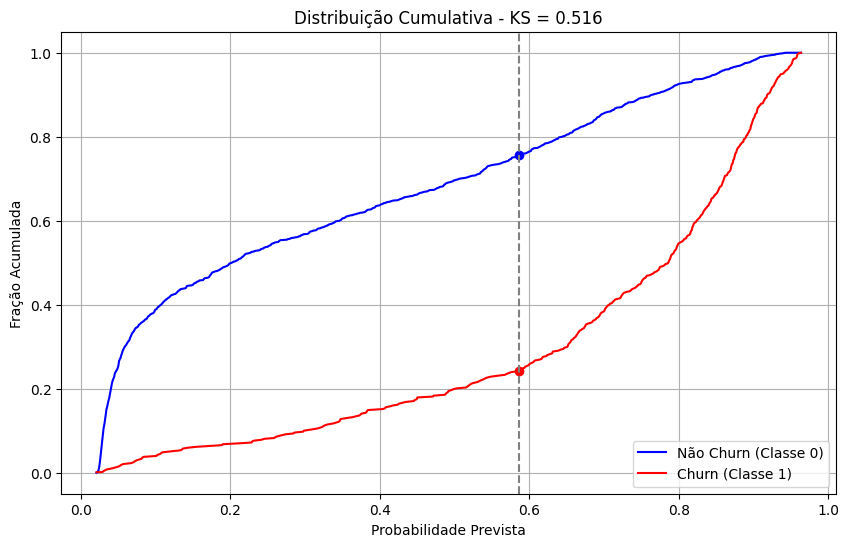

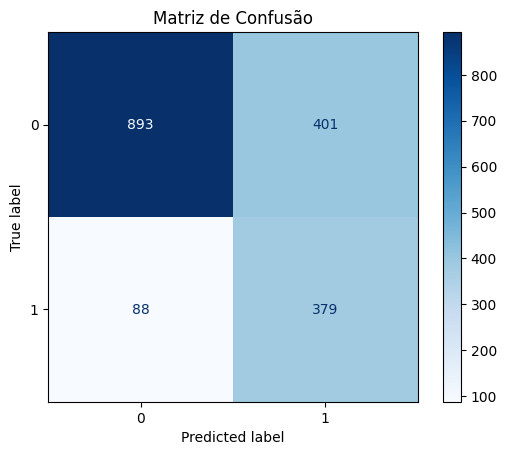

KS Statistic: 0.5155 (p-value: 4.712e-84)
AUC-ROC: 0.8316
F1 Score: 0.6079
AUC-PR: 0.6364
Matriz de Confusão:
[[893 401]
 [ 88 379]]


In [ ]:
results = evaluate_model_metrics(model, X_test, test_y)

## Optuna

In [ ]:
def calculate_ks(y_true, y_pred):
    """Calcula estatística KS entre as distribuições preditas para as classes 0 e 1."""
    preds_pos = y_pred[y_true == 1]
    preds_neg = y_pred[y_true == 0]
    ks_stat, _ = ks_2samp(preds_pos, preds_neg)
    return ks_stat

In [ ]:
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Sugestões de hiperparâmetros
    dim = trial.suggest_categorical("dim", [16, 32, 64])
    depth = trial.suggest_int("depth", 2, 11)
    heads = trial.suggest_categorical("heads", [2, 4, 8])
    attn_dp = trial.suggest_float("attn_dp", 0.0, 0.5, step=0.05)
    ff_dp = trial.suggest_float("ff_dp", 0.0, 0.3, step=0.05)
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    U = trial.suggest_categorical("U", [2,4,8])
    weight_decay = trial.suggest_float("wd", 1e-6, 1e-4, log=True)

    # Configurar modelo
    model = mainmodel.MainModel(
        categories=(2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4),  # deve ajustar conforme real
        num_continuous=3,
        dim=dim,
        depth=depth,
        heads=heads,
        attn_dropout=attn_dp,
        ff_dropout=ff_dp,
        U=U,
        cases=8,
    )
    model_wrapper = Num_Cat(model, num_number=3, classes=1, Sample_size=16)
    model_keras = keras4torch.Model(model_wrapper).build([19])  # ajuste input shape se precisar
    model_keras.to(device)

    optimizer = optim.AdamW(model_keras.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.BCEWithLogitsLoss()

    model_keras.compile(optimizer=optimizer, loss=loss_fn)

    # Mover dados para device
    X_train_t = torch.tensor(X_train).to(device)
    train_y_t = torch.tensor(train_y).to(device)
    X_valid_t = torch.tensor(X_valid).to(device)
    valid_y_t = torch.tensor(valid_y).to(device)

    # Treinamento rápido para o trial
    model_keras.fit(
        X_train_t, train_y_t,
        epochs=10,
        batch_size=64,
        validation_data=([X_valid_t], valid_y_t),
        verbose=0,
    )

    # Avaliar no conjunto de validação
    model_keras.eval()
    with torch.no_grad():
        preds = model_keras(X_valid_t).cpu().numpy().flatten()
        preds = 1 / (1 + np.exp(-preds))  # Sigmoid

    ks = calculate_ks(valid_y.flatten(), preds)
    return ks

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best KS:", study.best_value)
print("Best params:", study.best_params)

[I 2025-08-10 23:41:00,213] A new study created in memory with name: no-name-efee66a8-2587-4a53-ba1c-98895389874a


45


[I 2025-08-10 23:46:23,827] Trial 0 finished with value: 0.5098558312015389 and parameters: {'dim': 16, 'depth': 9, 'heads': 2, 'attn_dp': 0.0, 'ff_dp': 0.1, 'lr': 0.0001525893543838884, 'U': 4, 'wd': 6.901449113358345e-06}. Best is trial 0 with value: 0.5098558312015389.


45


[I 2025-08-10 23:49:34,758] Trial 1 finished with value: 0.5159388819481627 and parameters: {'dim': 64, 'depth': 5, 'heads': 2, 'attn_dp': 0.2, 'ff_dp': 0.1, 'lr': 0.000920800479655908, 'U': 4, 'wd': 2.2021347471092588e-06}. Best is trial 1 with value: 0.5159388819481627.


45


[I 2025-08-10 23:55:44,394] Trial 2 finished with value: 0.512200805124239 and parameters: {'dim': 64, 'depth': 10, 'heads': 8, 'attn_dp': 0.35000000000000003, 'ff_dp': 0.0, 'lr': 8.751163320326647e-05, 'U': 4, 'wd': 5.245872624968654e-05}. Best is trial 1 with value: 0.5159388819481627.


45


[I 2025-08-11 00:00:43,726] Trial 3 finished with value: 0.5134203898705059 and parameters: {'dim': 64, 'depth': 8, 'heads': 2, 'attn_dp': 0.05, 'ff_dp': 0.15000000000000002, 'lr': 0.00015121723456322053, 'U': 8, 'wd': 1.5502776135685277e-05}. Best is trial 1 with value: 0.5159388819481627.


45


[I 2025-08-11 00:04:31,492] Trial 4 finished with value: 0.5028407400797192 and parameters: {'dim': 64, 'depth': 6, 'heads': 4, 'attn_dp': 0.4, 'ff_dp': 0.3, 'lr': 5.60654533076809e-05, 'U': 2, 'wd': 6.229427380979342e-06}. Best is trial 1 with value: 0.5159388819481627.


45
